In [16]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

In [17]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [18]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round', "w_SvGms", "l_SvGms", "w_bpSaved", "l_bpSaved", "w_bpFaced", "l_bpFaced",'minutes'])
# "w_SvGms", "l_SvGms", "w_bpSaved", "l_bpSaved", "w_bpFaced", "l_bpFaced","minutes"

In [19]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check total number of rows, should be over 15k
row_count = len(df)
print(row_count)

surface                53
winner_hand             0
winner_ht              79
winner_age              3
loser_hand              1
loser_ht              227
loser_age               3
w_ace                 694
w_df                  694
w_svpt                694
w_1stIn               694
w_1stWon              694
w_2ndWon              694
l_ace                 694
l_df                  694
l_svpt                694
l_1stIn               694
l_1stWon              694
l_2ndWon              694
winner_rank            79
winner_rank_points     79
loser_rank            222
loser_rank_points     222
dtype: int64
2
17946


## Convert Categorical Variables to Numerical

In [20]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])
# df['round'] = round_encoder.fit_transform(df['round'])

In [21]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
1    9045
0    8901
Name: count, dtype: int64


In [22]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,188.0,30.6,1,185.0,25.6,10.0,3.0,80.0,...,2.0,82.0,49.0,39.0,20.0,52.0,909.0,47.0,1010.0,1
1,2,1,188.0,21.2,1,183.0,23.7,5.0,3.0,58.0,...,5.0,62.0,41.0,25.0,7.0,54.0,890.0,94.0,593.0,0
2,2,1,185.0,31.3,1,175.0,25.6,7.0,0.0,94.0,...,6.0,120.0,53.0,37.0,29.0,63.0,809.0,30.0,1391.0,0
3,2,1,183.0,18.8,1,188.0,28.0,9.0,3.0,66.0,...,2.0,80.0,43.0,33.0,17.0,208.0,245.0,44.0,1055.0,0
4,2,0,193.0,27.2,1,188.0,19.9,4.0,0.0,45.0,...,4.0,55.0,38.0,32.0,11.0,68.0,755.0,175.0,299.0,1


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,183.0,28.2,1,175.0,25.0,2.0,1.0,50.0,...,2.0,52.0,32.0,25.0,11.0,819.0,24.0,569.0,64.0,1
3066,2,1,188.0,28.8,1,178.0,31.0,3.0,2.0,49.0,...,2.0,56.0,35.0,30.0,11.0,900.0,18.0,279.0,205.0,1
3068,0,1,188.0,21.8,0,185.0,23.9,0.0,5.0,92.0,...,2.0,74.0,50.0,31.0,13.0,740.0,34.0,616.0,55.0,1
3070,0,1,175.0,34.2,0,185.0,23.9,2.0,1.0,50.0,...,1.0,82.0,66.0,33.0,6.0,136.0,489.0,616.0,55.0,0
3074,2,1,175.0,26.9,1,185.0,27.3,0.0,1.0,84.0,...,3.0,86.0,51.0,32.0,17.0,554.0,67.0,416.0,109.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 17946 entries, 0 to 3074
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17946 non-null  int64  
 1   p1_hand         17946 non-null  int64  
 2   p1_ht           17946 non-null  float64
 3   p1_age          17946 non-null  float64
 4   p2_hand         17946 non-null  int64  
 5   p2_ht           17946 non-null  float64
 6   p2_age          17946 non-null  float64
 7   p1_ace          17946 non-null  float64
 8   p1_df           17946 non-null  float64
 9   p1_svpt         17946 non-null  float64
 10  p1_1stIn        17946 non-null  float64
 11  p1_1stWon       17946 non-null  float64
 12  p1_2ndWon       17946 non-null  float64
 13  p2_ace          17946 non-null  float64
 14  p2_df           17946 non-null  float64
 15  p2_svpt         17946 non-null  float64
 16  p2_1stIn        17946 non-null  float64
 17  p2_1stWon       17946 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,...,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000
mean,1.285468,0.858241,187.228352,27.165112,0.864427,187.231361,27.096590,6.340187,2.940098,81.064025,...,2.926557,81.029199,50.494929,36.115792,15.526858,79.427059,1530.287975,79.199543,1543.164828,0.504012
std,0.901457,0.348812,6.897030,4.582036,0.342345,7.271273,4.561145,5.406776,2.439238,29.367945,...,2.448001,29.063028,19.145647,14.161335,6.891079,104.156451,1725.818363,111.363877,1742.079623,0.499998
min,0.000000,0.000000,168.000000,16.400000,0.000000,15.000000,16.500000,0.000000,0.000000,3.000000,...,0.000000,4.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,183.000000,23.600000,1.000000,183.000000,23.600000,2.000000,1.000000,59.000000,...,1.000000,59.000000,37.000000,26.000000,11.000000,26.000000,641.000000,25.000000,649.000000,0.000000
50%,2.000000,1.000000,188.000000,26.800000,1.000000,188.000000,26.700000,5.000000,2.000000,76.000000,...,2.000000,76.000000,47.000000,34.000000,14.000000,55.000000,946.000000,55.000000,955.000000,1.000000
75%,2.000000,1.000000,193.000000,30.300000,1.000000,193.000000,30.200000,9.000000,4.000000,97.000000,...,4.000000,97.000000,61.000000,44.000000,19.000000,94.000000,1634.500000,94.000000,1650.000000,1.000000
max,2.000000,1.000000,211.000000,42.500000,1.000000,211.000000,42.300000,59.000000,26.000000,291.000000,...,26.000000,278.000000,198.000000,166.000000,52.000000,1821.000000,12415.000000,2146.000000,12415.000000,1.000000


In [23]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


## Drop Nulls

In [24]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17946


## Scale Features

In [25]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([1, 0, 0, ..., 1, 0, 0])

array([[ 0.79266389,  0.40641525,  0.11188435, ..., -0.36000619,
        -0.28914619, -0.30605931],
       [ 0.79266389,  0.40641525,  0.11188435, ..., -0.37101576,
         0.13290548, -0.54543506],
       [ 0.79266389,  0.40641525, -0.32309758, ..., -0.41795133,
        -0.44180317, -0.08734909],
       ...,
       [-1.42602849,  0.40641525,  0.11188435, ..., -0.86702616,
         4.82037289, -0.85426996],
       [-1.42602849,  0.40641525, -1.77303734, ..., -0.60337577,
         4.82037289, -0.85426996],
       [ 0.79266389,  0.40641525, -1.77303734, ..., -0.84790426,
         3.02440836, -0.82327166]])

## Split data into testing and training

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([0, 1, 1, ..., 0, 0, 1])

### Reusable function for evaluation

In [27]:
# Create a global list to collect model results
model_results = []

def evaluate_model(y_pred_test, y_pred_train, model_name):
    # Calculate test metrics
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average='binary')
    recall_test = recall_score(y_test, y_pred_test, average='binary')
    f1_test = f1_score(y_test, y_pred_test, average='binary')

    # Calculate train metrics
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average='binary')
    recall_train = recall_score(y_train, y_pred_train, average='binary')
    f1_train = f1_score(y_train, y_pred_train, average='binary')

    # Print the metrics
    print("=== Test Metrics ===")
    print(f"Accuracy: {accuracy_test}")
    print(f"Precision: {precision_test}")
    print(f"Recall: {recall_test}")
    print(f"F1 Score: {f1_test}")

    print("\n=== Training Metrics ===")
    print(f"Accuracy: {accuracy_train}")
    print(f"Precision: {precision_train}")
    print(f"Recall: {recall_train}")
    print(f"F1 Score: {f1_train}")

    print("\nX_train shape:", X_train.shape)

    # Confusion matrix for test data
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix (Test Data) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Add results to the model_results table
    model_results.append({
        "Model": model_name,
        "Train Accuracy": accuracy_train,
        "Train Precision": precision_train,
        "Train Recall": recall_train,
        "Train F1": f1_train,
        "Test Accuracy": accuracy_test,
        "Test Precision": precision_test,
        "Test Recall": recall_test,
        "Test F1": f1_test
    })

In [28]:
def iterative_feature_elimination(clf, X_train, y_train, X_test, y_test, feature_names=None, target_name='winner'):    
    baseline_f1 = f1_score(y_test, clf.predict(X_test))
    print(f"Baseline F1: {baseline_f1:.4f}")
    
    if feature_names is None:
        # Try to infer feature names from a DataFrame if not provided
        try:
            feature_names = X_train.columns.tolist()
        except AttributeError:
            feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    
    current_X_train = X_train.copy()
    current_X_test = X_test.copy()
    features = feature_names.copy()
    removed_features = []

    while len(features) > 1:
        selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
        selector.fit(current_X_train, y_train)

        new_f1 = f1_score(y_test, selector.predict(current_X_test))
        dropped_idx = np.where(~selector.support_)[0][0]
        dropped_feat = features[dropped_idx]

        if new_f1 < baseline_f1:
            removed_features.append(dropped_feat)
            print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
            break

        removed_features.append(dropped_feat)
        print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

        features.pop(dropped_idx)
        current_X_train = current_X_train[:, selector.support_]
        current_X_test = current_X_test[:, selector.support_]

    print(f"\nTotal removed: {len(removed_features)} features")
    print("Features removed (in order):")
    for feat in removed_features:
        print(f" - {feat}")

    return removed_features, features, new_f1

## Neural Network

In [29]:
# Shallow model for binary classification
shallow_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')  # Single output node with sigmoid for binary classification
])

shallow_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

shallow_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

shallow_test_loss, shallow_test_acc = shallow_model.evaluate(X_test, y_test, verbose=0)

y_pred = (shallow_model.predict(X_test) > 0.5).astype(int).flatten()

shallow_test_precision = precision_score(y_test, y_pred)
shallow_test_recall = recall_score(y_test, y_pred)
shallow_test_f1 = f1_score(y_test, y_pred)

print(f'Shallow Network Test Accuracy: {shallow_test_acc:.4f}')
print(f'Precision: {shallow_test_precision:.4f}')
print(f'Recall: {shallow_test_recall:.4f}')
print(f'F1 Score: {shallow_test_f1:.4f}')

C:\Users\mathe\anaconda3\envs\machineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7202 - loss: 0.5571 - val_accuracy: 0.8409 - val_loss: 0.3787
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8713 - loss: 0.3328 - val_accuracy: 0.9074 - val_loss: 0.2506
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9252 - loss: 0.2208 - val_accuracy: 0.9356 - val_loss: 0.1782
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9439 - loss: 0.1620 - val_accuracy: 0.9405 - val_loss: 0.1544
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9466 - loss: 0.1407 - val_accuracy: 0.9398 - val_loss: 0.1475
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9483 - loss: 0.1358 - val_accuracy: 0.9439 - val_loss: 0.1408
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9520 - loss: 0.1297 - val_accuracy: 0.9425 - val_loss: 0.1367
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9493 - loss: 0.1259 - val_accuracy: 0.

In [30]:
# Deep model for binary classification
deep_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

deep_model_loss, deep_model_acc = shallow_model.evaluate(X_test, y_test, verbose=0)

y_pred = (shallow_model.predict(X_test) > 0.5).astype(int).flatten()

deep_model_precision = precision_score(y_test, y_pred)
deep_model_recall = recall_score(y_test, y_pred)
deep_model_f1 = f1_score(y_test, y_pred)

print(f'Shallow Network Test Accuracy: {deep_model_acc:.4f}')
print(f'Precision: {deep_model_precision:.4f}')
print(f'Recall: {deep_model_recall:.4f}')
print(f'F1 Score: {deep_model_f1:.4f}')

# Evaluate on test data
deep_test_loss, deep_test_acc = deep_model.evaluate(X_test, y_test, verbose=0)
print(f'Deep Network Test Accuracy: {deep_test_acc:.4f}')

Epoch 1/20


C:\Users\mathe\anaconda3\envs\machineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7652 - loss: 0.4777 - val_accuracy: 0.9164 - val_loss: 0.2003
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9301 - loss: 0.1759 - val_accuracy: 0.9373 - val_loss: 0.1520
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9433 - loss: 0.1441 - val_accuracy: 0.9387 - val_loss: 0.1464
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9489 - loss: 0.1275 - val_accuracy: 0.9363 - val_loss: 0.1454
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9512 - loss: 0.1220 - val_accuracy: 0.9366 - val_loss: 0.1461
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9503 - loss: 0.1194 - val_accuracy: 0.9338 - val_loss: 0.1650
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9561 - loss: 0.1113 - val_accuracy: 0.9373 - val_loss: 0.1512
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9605 - loss: 0.1027 - val_accuracy: 0.9380 - val_

## Logistic Regression

=== Test Metrics ===
Accuracy: 0.9426183844011142
Precision: 0.939943342776204
Recall: 0.9431495167708925
F1 Score: 0.9415437003405221

=== Training Metrics ===
Accuracy: 0.9489412092504876
Precision: 0.9498832898530826
Recall: 0.9494921767773813
F1 Score: 0.9496876930468804

X_train shape: (14356, 23)


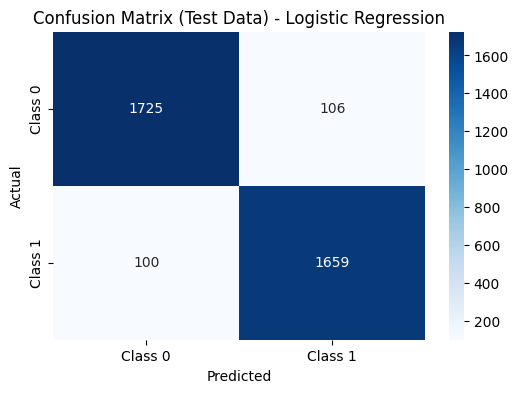

In [31]:
from sklearn.linear_model import LogisticRegression

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Logistic Regression")

### Bagging

=== Test Metrics ===
Accuracy: 0.9428969359331476
Precision: 0.9394796380090498
Recall: 0.9442865264354747
F1 Score: 0.9418769492486533

=== Training Metrics ===
Accuracy: 0.9490108665366397
Precision: 0.9497666758166347
Recall: 0.9497666758166347
F1 Score: 0.9497666758166347

X_train shape: (14356, 23)


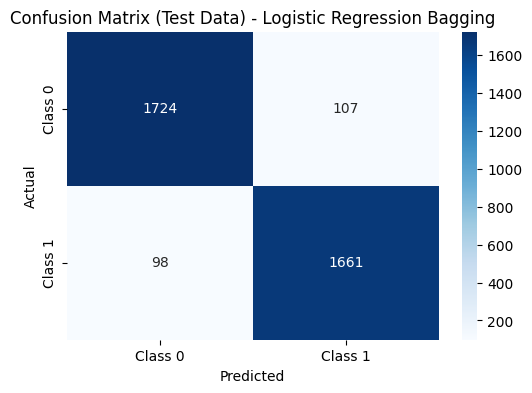

In [32]:
from sklearn.ensemble import BaggingClassifier
# Use logistic model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Logistic Regression Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.922841225626741
Precision: 0.9167604049493814
Recall: 0.9266628766344513
F1 Score: 0.9216850438224484

=== Training Metrics ===
Accuracy: 0.9298551128448036
Precision: 0.9320214669051878
Recall: 0.9295909964315124
F1 Score: 0.9308046450903594

X_train shape: (14356, 23)


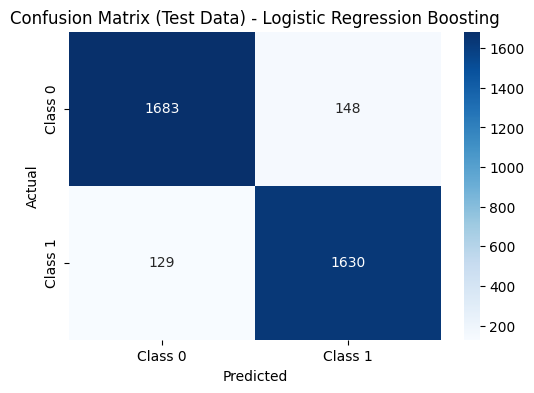

In [33]:
from sklearn.ensemble import AdaBoostClassifier
# Use logistic model 
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Logistic Regression Boosting")

## Wrapper Method
running the RFE wrapper method recursively until the percision value begins decreasing from the elimination of Features within the dataset

In [ ]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

## Decision Tree

=== Test Metrics ===
Accuracy: 0.6554317548746518
Precision: 0.7868131868131868
Recall: 0.4070494599204093
F1 Score: 0.5365305357811915

=== Training Metrics ===
Accuracy: 0.6538032878239064
Precision: 0.8267494356659142
Recall: 0.40214109250617625
F1 Score: 0.541089566020314

X_train shape: (14356, 23)


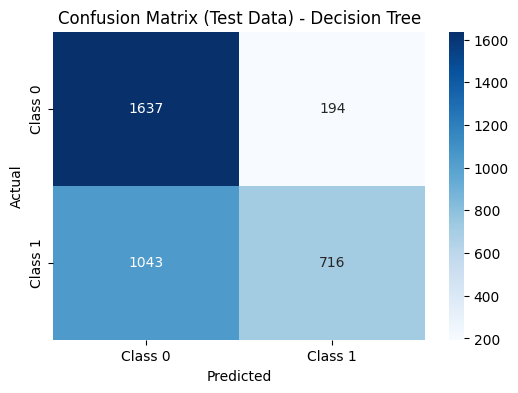

In [34]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Decision Tree")

### Bagging

=== Test Metrics ===
Accuracy: 0.7133704735376044
Precision: 0.7436582109479306
Recall: 0.633314383172257
F1 Score: 0.684065090574148

=== Training Metrics ===
Accuracy: 0.7179576483700195
Precision: 0.7706069219194115
Recall: 0.6325830359593742
F1 Score: 0.6948066631491671

X_train shape: (14356, 23)


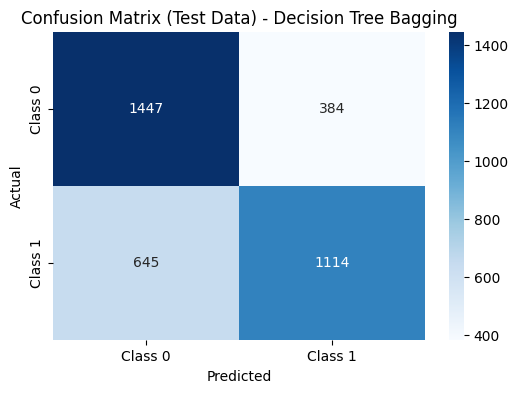

In [36]:
# Use decision tree model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Decision Tree Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.9155988857938718
Precision: 0.9150513112884835
Recall: 0.9124502558271745
F1 Score: 0.9137489325362937

=== Training Metrics ===
Accuracy: 0.9628726664809139
Precision: 0.964762560220234
Recall: 0.9619818830634093
F1 Score: 0.963370215105491

X_train shape: (14356, 23)


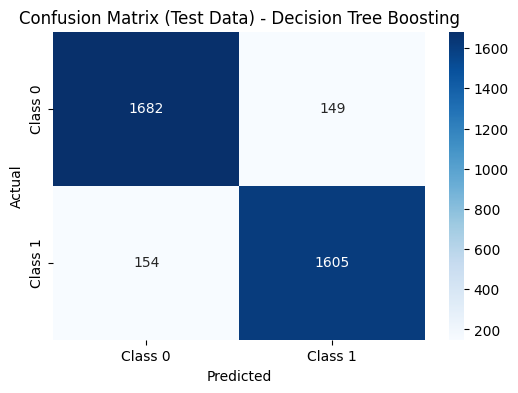

In [37]:
# Use decision tree model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Decision Tree Boosting")

## Wrapper Methods

In [ ]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

## Random Forest

=== Test Metrics ===
Accuracy: 0.7991643454038997
Precision: 0.7766524520255863
Recall: 0.8283115406480955
F1 Score: 0.8016506189821183

=== Training Metrics ===
Accuracy: 0.8877821120089161
Precision: 0.8780812791472352
Recall: 0.9044743343398298
F1 Score: 0.8910824149820837

X_train shape: (14356, 23)


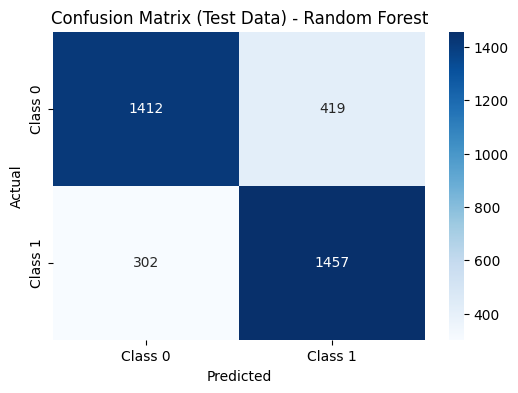

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Random Forest")

### Bagging

=== Test Metrics ===
Accuracy: 0.8005571030640668
Precision: 0.7781333333333333
Recall: 0.8294485503126776
F1 Score: 0.8029719317556412

=== Training Metrics ===
Accuracy: 0.8806074115352466
Precision: 0.8710708577517314
Recall: 0.8976118583584958
F1 Score: 0.8841422198188454

X_train shape: (14356, 23)


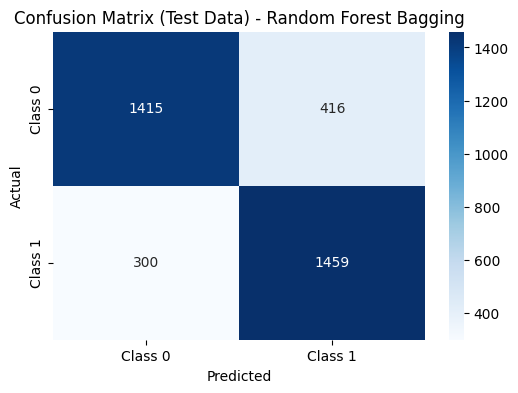

In [39]:
# Use random forest model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Random Forest Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.89025069637883
Precision: 0.8802228412256268
Recall: 0.8982376350198976
F1 Score: 0.8891389983117614

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


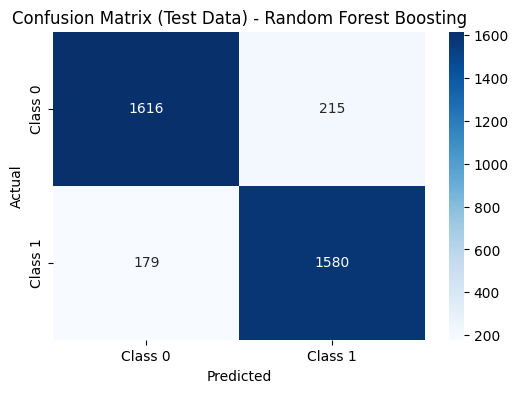

In [40]:
# Use random forest model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Random Forest Boosting")

## Wrapper Methods

In [ ]:
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")

## KNN

=== Test Metrics ===
Accuracy: 0.7537604456824513
Precision: 0.7231004589495156
Recall: 0.8061398521887436
F1 Score: 0.7623655913978494

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


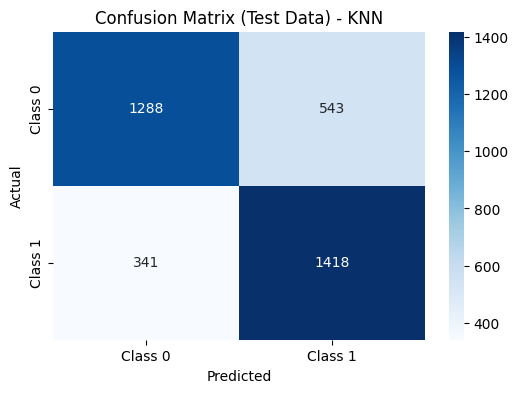

In [41]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit the model
neigh = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

# Predictions
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"KNN")

### Bagging

=== Test Metrics ===
Accuracy: 0.8005571030640668
Precision: 0.7781333333333333
Recall: 0.8294485503126776
F1 Score: 0.8029719317556412

=== Training Metrics ===
Accuracy: 0.8806074115352466
Precision: 0.8710708577517314
Recall: 0.8976118583584958
F1 Score: 0.8841422198188454

X_train shape: (14356, 23)


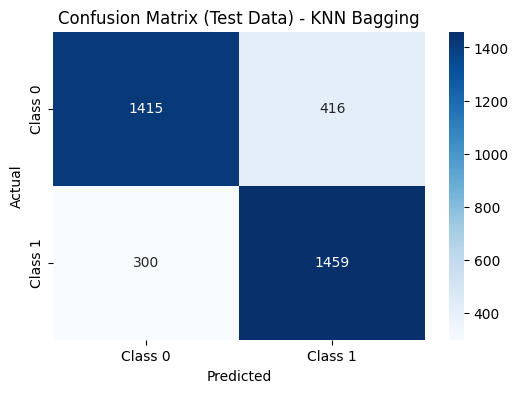

In [42]:
# Use KNN model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"KNN Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.89025069637883
Precision: 0.8802228412256268
Recall: 0.8982376350198976
F1 Score: 0.8891389983117614

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


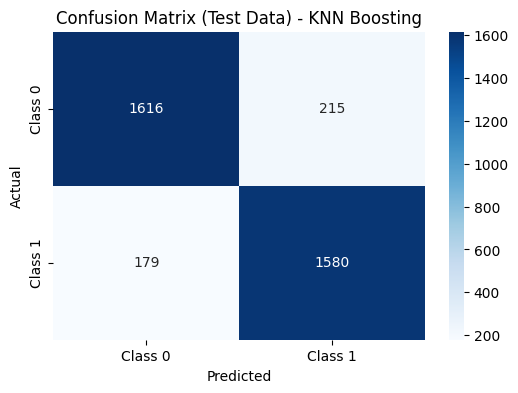

In [43]:
# Use KNN model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"KNN Boosting")

## Wrapper Method

In [ ]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

## SVM Linear Kernel

=== Test Metrics ===
Accuracy: 0.9426183844011142
Precision: 0.9394453876627051
Recall: 0.9437180216031836
F1 Score: 0.9415768576290414

=== Training Metrics ===
Accuracy: 0.9490805238227918
Precision: 0.9498970487302677
Recall: 0.9497666758166347
F1 Score: 0.9498318577997392

X_train shape: (14356, 23)


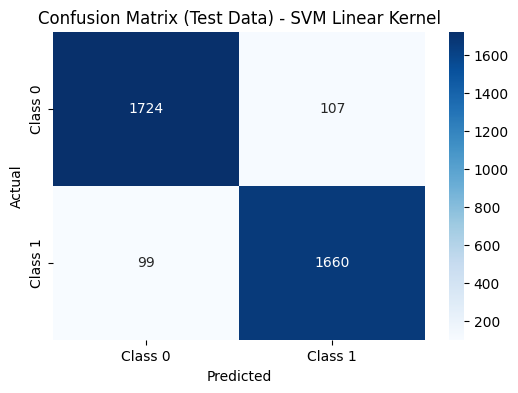

In [44]:
from sklearn.svm import LinearSVC

# Train the model
clf = LinearSVC(random_state=0, tol=1e-5, C=1.0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"SVM Linear Kernel")

### Bagging

=== Test Metrics ===
Accuracy: 0.9426183844011142
Precision: 0.939943342776204
Recall: 0.9431495167708925
F1 Score: 0.9415437003405221

=== Training Metrics ===
Accuracy: 0.9490805238227918
Precision: 0.9495268138801262
Recall: 0.9501784243755147
F1 Score: 0.9498525073746312

X_train shape: (14356, 23)


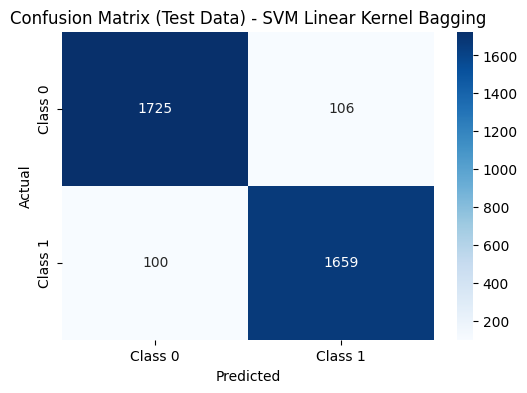

In [45]:
# Use linear SVM model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"SVM Linear Kernel Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.9298050139275766
Precision: 0.9278818852924475
Recall: 0.9289368959636157
F1 Score: 0.928409090909091

=== Training Metrics ===
Accuracy: 0.9358456394538869
Precision: 0.9355412618037499
Recall: 0.9382377161679935
F1 Score: 0.936887548824779

X_train shape: (14356, 23)


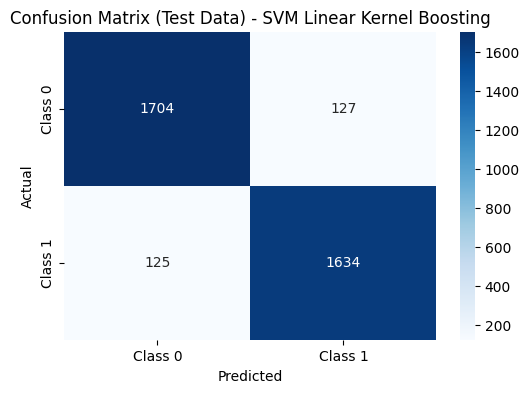

In [46]:
# Use linear SVM model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "SVM Linear Kernel Boosting")

## Wrapper Method

In [ ]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

## SVM Gaussian Kernel

=== Test Metrics ===
Accuracy: 0.9362116991643454
Precision: 0.9259465478841871
Recall: 0.9454235361000568
F1 Score: 0.9355836849507736

=== Training Metrics ===
Accuracy: 0.9584146001671775
Precision: 0.9575865371459844
Recall: 0.9606093878671425
F1 Score: 0.9590955806783145

X_train shape: (14356, 23)


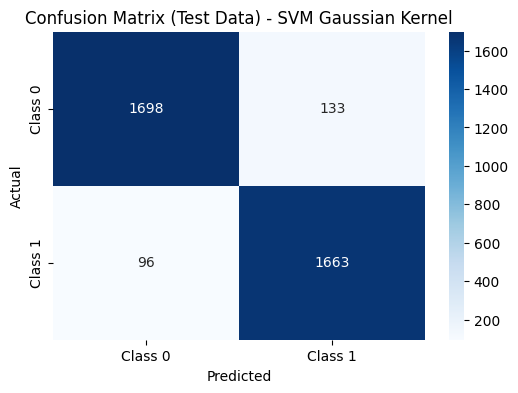

In [47]:
from sklearn.svm import SVC

# Train the model
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
clf.fit(X_train, y_train)

# Make predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train, "SVM Gaussian Kernel")

### Bagging

=== Test Metrics ===
Accuracy: 0.9370473537604457
Precision: 0.9294117647058824
Recall: 0.9431495167708925
F1 Score: 0.9362302483069977

=== Training Metrics ===
Accuracy: 0.9582056283087211
Precision: 0.9585733882030179
Recall: 0.959099643151249
F1 Score: 0.9588364434687157

X_train shape: (14356, 23)


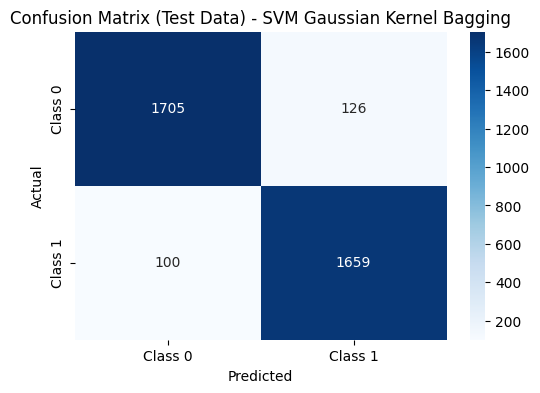

In [48]:
# Use gaussian SVM model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "SVM Gaussian Kernel Bagging")

# Note: Boosting results in the model predicting all 1s

## Stacking

### Decision Tree, KNN, & Random Forest -> Logistic

=== Test Metrics ===
Accuracy: 0.8161559888579387
Precision: 0.8014262205156336
Recall: 0.8305855599772598
F1 Score: 0.8157453936348409

=== Training Metrics ===
Accuracy: 0.9989551407077181
Precision: 0.9990391214824983
Recall: 0.9989020038429866
F1 Score: 0.9989705579575869

X_train shape: (14356, 23)


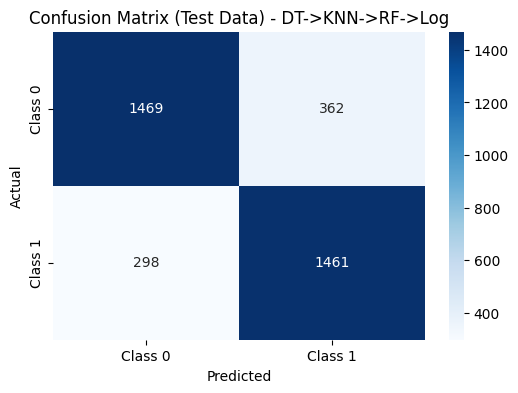

In [50]:
from sklearn.ensemble import StackingClassifier
estimators = [
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')],
  ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"DT->KNN->RF->Log")

### Logistic & KNN -> Decision Tree

=== Test Metrics ===
Accuracy: 0.9253481894150418
Precision: 0.9219015280135824
Recall: 0.9260943718021604
F1 Score: 0.9239931934203063

=== Training Metrics ===
Accuracy: 0.8989272777932572
Precision: 0.9004804392587509
Recall: 0.9003568487510294
F1 Score: 0.9004186397639147

X_train shape: (14356, 23)


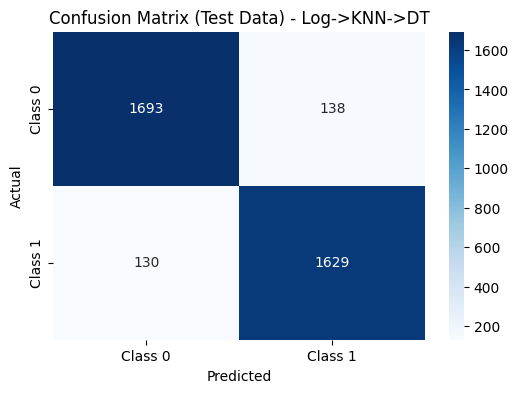

In [51]:
estimators = [
  ["LogisticRegression", LogisticRegression(random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Log->KNN->DT")

### Gaussian SVC -> Logistic

=== Test Metrics ===
Accuracy: 0.935933147632312
Precision: 0.9263803680981595
Recall: 0.9442865264354747
F1 Score: 0.9352477477477478

=== Training Metrics ===
Accuracy: 0.9585539147394817
Precision: 0.9582249006985345
Recall: 0.9601976393082624
F1 Score: 0.9592102557071365

X_train shape: (14356, 23)


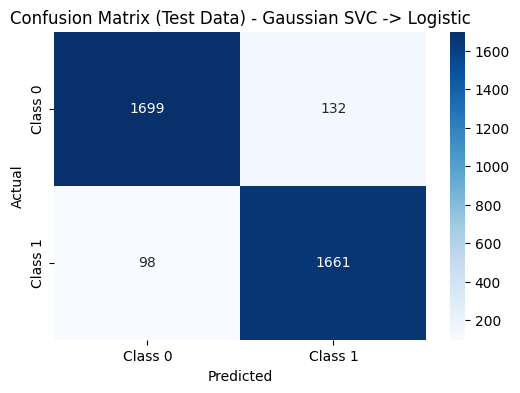

In [52]:
estimators = [
  ["SVC", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)],
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Gaussian SVC -> Logistic")

In [55]:
pd.DataFrame(model_results)

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Logistic Regression,0.948941,0.949883,0.949492,0.949688,0.942618,0.939943,0.943150,0.941544
1,Logistic Regression Bagging,0.949011,0.949767,0.949767,0.949767,0.942897,0.939480,0.944287,0.941877
2,Logistic Regression Boosting,0.929855,0.932021,0.929591,0.930805,0.922841,0.916760,0.926663,0.921685
3,Decision Tree,0.653803,0.826749,0.402141,0.541090,0.655432,0.786813,0.407049,0.536531
4,Decision Tree Bagging,0.717958,0.770607,0.632583,0.694807,0.713370,0.743658,0.633314,0.684065
5,Decision Tree Boosting,0.962873,0.964763,0.961982,0.963370,0.915599,0.915051,0.912450,0.913749
6,Random Forest,0.887782,0.878081,0.904474,0.891082,0.799164,0.776652,0.828312,0.801651
7,Random Forest Bagging,0.880607,0.871071,0.897612,0.884142,0.800557,0.778133,0.829449,0.802972
8,Random Forest Boosting,1.000000,1.000000,1.000000,1.000000,0.890251,0.880223,0.898238,0.889139
9,KNN,1.000000,1.000000,1.000000,1.000000,0.753760,0.723100,0.806140,0.762366


In [62]:
def plot_model_results(results_df):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    melted_df = pd.melt(
        results_df,
        id_vars=['Model'],
        value_vars=[f'Train {m}' for m in metrics] + [f'Test {m}' for m in metrics],
        var_name='Metric Type',
        value_name='Score'
    )

    # Split Metric Type into two columns: Data Split and Metric
    melted_df[['Split', 'Metric']] = melted_df['Metric Type'].str.extract(r'(Train|Test)\s+(.*)')

    # Plot
    g = sns.catplot(
        data=melted_df,
        kind='bar',
        x='Model',
        y='Score',
        hue='Split',
        col='Metric',
        col_wrap=2,
        height=4,
        aspect=1.2,
        palette='Set2',
        sharey=False
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Model", "Score")
    g.set_xticklabels(rotation=45)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Training vs Test Metrics by Model")
    plt.show()

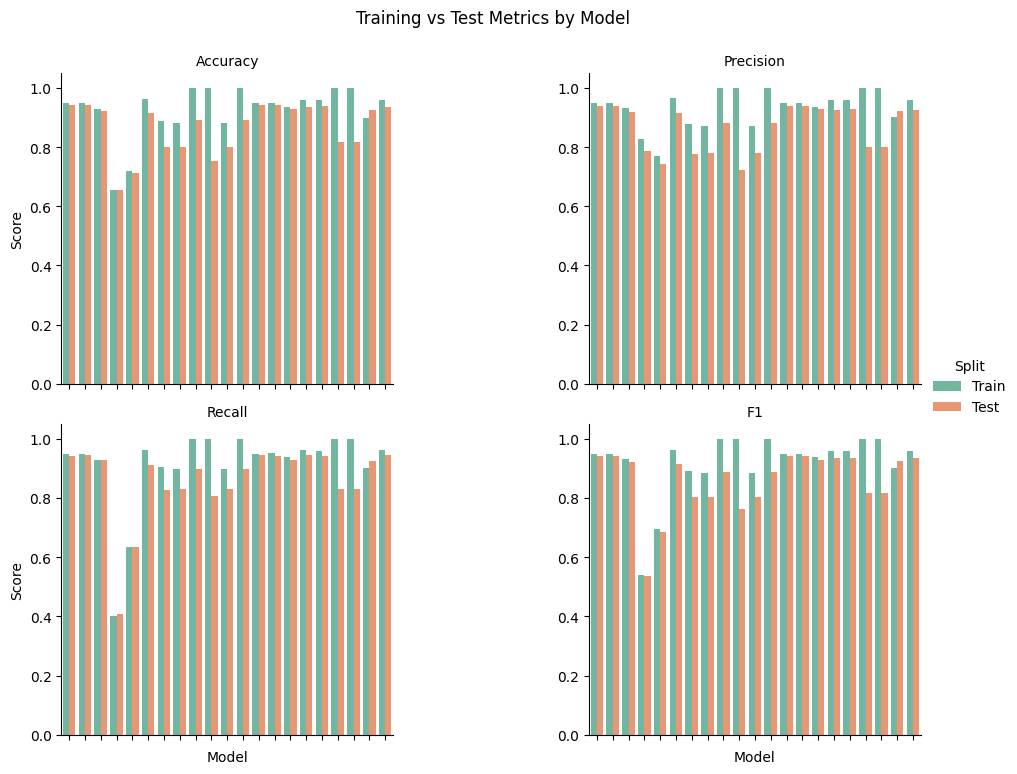

In [63]:
plot_model_results(pd.DataFrame(model_results))

## KNN With HyperTuning

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# import pandas as pd

# param_grid = {
#     "n_neighbors": [100, 200],
#     "weights":     ["uniform", "distance"],
#     "metric":      ["euclidean", "manhattan"],
#     "algorithm":   ["auto", "kd_tree", "ball_tree"]
# }

# grid_knn = GridSearchCV(
#     estimator   = KNeighborsClassifier(),
#     param_grid  = param_grid,
#     scoring     = "balanced_accuracy",
#     verbose     = 0
# )

# grid_knn.fit(X_train, y_train)

# print("Best hyper‑parameters:", grid_knn.best_params_)
# print(f"Best score (train only): {grid_knn.best_score_:.4f}")

# best_knn      = grid_knn.best_estimator_
# y_pred_test   = best_knn.predict(X_test)
# y_pred_train  = best_knn.predict(X_train)

# # Custom evaluation
# evaluate_model(y_pred_test, y_pred_train)

# results = pd.DataFrame(grid_knn.cv_results_)
# top5 = results.sort_values(by="mean_test_score", ascending=False).head()

# print("Top 5 configs:")
# print(top5[["params", "mean_test_score"]])

## DecisionTreeClassifier with Hypertuning

=== Test Metrics ===
Accuracy: 0.7710306406685237
Precision: 0.7757504414361389
Recall: 0.7492893689596362
F1 Score: 0.7622903412377097

=== Training Metrics ===
Accuracy: 0.8170103092783505
Precision: 0.8355177876998415
Recall: 0.7961844633543783
F1 Score: 0.8153770468760981

X_train shape: (14356, 23)


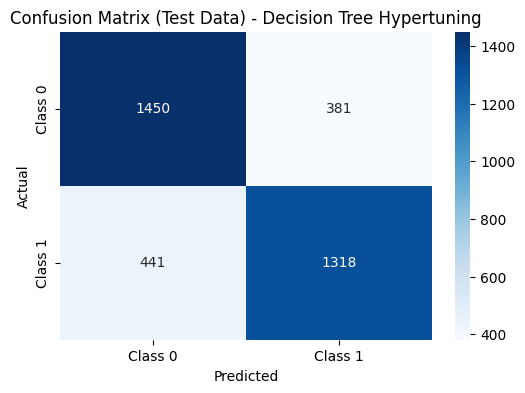

In [64]:
from sklearn.tree import DecisionTreeClassifier

dt_manual = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)
dt_manual.fit(X_train, y_train)

y_pred_test  = dt_manual.predict(X_test)
y_pred_train = dt_manual.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Decision Tree Hypertuning")

## Logistic Regression With Hypertuning

In [ ]:
# # Tried on this one but not much change, running gridsearch on all will blow up our computers

# # testing elastic 
# from sklearn.linear_model import LogisticRegression

# log_manual = LogisticRegression(
#     penalty="elasticnet",
#     C=1.0,
#     l1_ratio=0.5,
#     class_weight="balanced",
#     solver="saga",
#     max_iter=10000,
#     random_state=42
# )
# log_manual.fit(X_train, y_train)

# y_pred_test  = log_manual.predict(X_test)
# y_pred_train = log_manual.predict(X_train)

# evaluate_model(y_pred_test, y_pred_train)